# Curve di possibilità pluviometrica

In [1]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np

from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from pylab import plot,show,hist,figure,title

In [2]:
os_DatiFedaia=os.getcwd()
os.chdir(os_DatiFedaia)

In [3]:
data=pd.read_csv('DatiFedaiaSub.csv')

In [4]:
map(datetime,data['Anno'])
data=data.set_index('Anno')

### Definizione dei tempi di ritorno e delle durate prefissate

In [11]:
def indici(cols,dic):
    indi=[]
    
    for x in cols:
        for i,j in dic.items():
            x=x.replace(i,j)
        indi.append(int(x)) 
    return indi

h=[]
for i in range(len(data.columns)):
    h.append(data.columns[i])

car_to_replace={'min':'','ora':'','ore':'','giorno':'','giorni':''}

ind=indici(h,car_to_replace) #ind=[1,3,6,12,24]
r=[10,20,100,500] #Tempi di ritorno in anni

indx=[]
for i in r:
    indx.append('Tr='+str(i))

In [12]:
ind

[15, 30, 45, 1, 3, 6, 12, 24, 1, 2, 3, 4, 5]

In [13]:
best=pd.read_pickle("best_param")
best

,15min,30min,45min,1ora,3ore,6ore,12ore,24ore,1giorno,2giorni,3giorni,4giorni,5giorni
a,7.968888,9.510462,10.926104,12.601354,22.728162,31.960715,48.746973,66.168039,61.988983,87.992147,98.215226,106.758154,111.564329
b,2.852050,2.721378,2.591708,3.002031,5.338338,9.341875,13.646262,24.067697,20.564437,24.175602,25.775174,29.724126,31.780342


#q10=1-1/10 prob di non superamento
#q20=1-1/20
#q100=1-1/100
#q200=1-1/200

### Funzione che ritorna la probabilità di non superamento

In [14]:
def qn(n): #n tempo di ritorno
    return 1-1/n #probabilità di non superamento

### Si definisce una funzione che mi ritorna i quantili

In [15]:
def qtls(df,qu):
    return gumbel_r.ppf(qu,loc=df["a"],scale=df["b"])

### Valori dei quantili 
#### con i parametri migliori per ogni durata ed ogni tempo di ritorno

In [16]:
pts1=[]
pts0=[]
for i in h:
    for j in r:    
        pts0.append(qtls(best[i],qn(j)))
    pts1.append(pts0)
    pts0=[]

pts1
pts= DataFrame(pts1,index=ind, columns=r)
pts

,10,20,100,500
15,14.387047,16.440032,21.088741,25.690404
30,15.634562,17.593486,22.029207,26.420036
45,16.758400,18.623984,22.848349,27.029961
1,19.357026,21.517972,26.411144,31.254795
3,34.741383,38.584068,47.285313,55.898498
6,52.983364,59.707907,74.934732,90.007455
12,79.456076,89.279036,111.521815,133.539487
24,120.329198,137.653798,176.883037,215.715256
1,108.266520,123.069376,156.588462,189.768318
2,142.396131,159.798404,199.203523,238.209842


### Impostazione dei grafici

In [17]:
SMALL_SIZE=15
MEDIUM_SIZE=20
BIGGER_SIZE=30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [18]:
import random
colors={}
c=[]
for i in r:
    colore=(random.random(), random.random(), random.random())
    colors.update({i:colore})
    c.append(colors[i])

### Grafico delle altezze di precipitazione

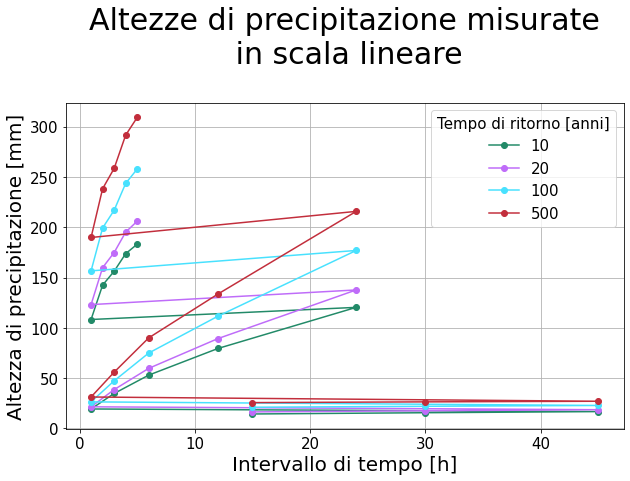

In [19]:
ag=pts.plot(style="-o",figsize=(10,6),color=c)
ag.set_title('Altezze di precipitazione misurate\n in scala lineare\n')
ag.set_ylabel('Altezza di precipitazione [mm]')
ag.set_xlabel('Intervallo di tempo [h]')
ag.grid(True)
ag.legend (title= "Tempo di ritorno [anni]")
#plt.ylim([0,200])


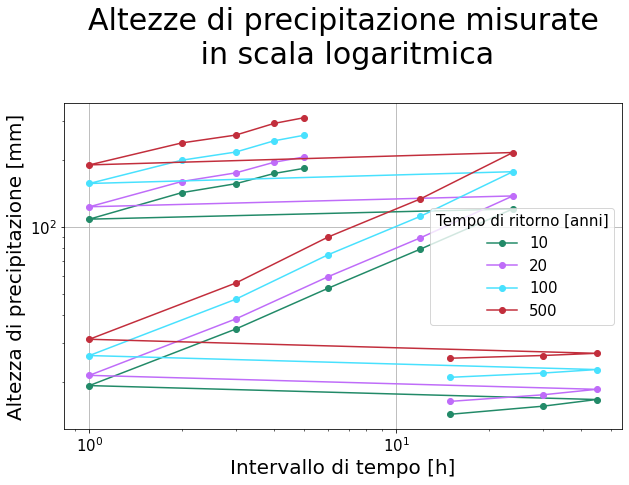

In [20]:
ag=pts.plot(style="-o",figsize=(10,6),color=c)
ag.set_yscale('log')
ag.set_xscale('log')
ag.set_title('Altezze di precipitazione misurate\n in scala logaritmica\n')
ag.set_ylabel('Altezza di precipitazione [mm]')
ag.set_xlabel('Intervallo di tempo [h]')
ag.grid(True)
ag.legend (title= "Tempo di ritorno [anni]")
#plt.ylim([0,200])

### Con un metodo di regressione ottendo i parametri 'a(Tr)' e 'n'

In [14]:
In=[]
a=0
for j in r:
    In.append(np.polyfit(np.log(ind),np.log(pts[j]),1))
    In[a][1]=np.exp(In[a][1])
    a+=1

In [15]:
fnl=DataFrame(In,index=r,columns=['n','a']) 
fnl

,n,a
10,0.578487,18.863078
20,0.587302,20.862302
100,0.601473,25.398322
500,0.610825,29.895471


In [16]:
tp=np.linspace(0.7,30,100) 

### Funzione delle curve di possibilità pluviometrica

In [17]:
def h(tp,a,n): 
    return a*tp**n

### Dataframe con le altezze di precipitazione in funzione della durata prefissata assegnato il tempo di ritorno

In [18]:
hh=[]
for i in r:
    hh.append(h(tp,fnl['a'][i],fnl['n'][i]))

inh=DataFrame(hh,index=indx, columns=tp).T

### Si Graficano i risultati

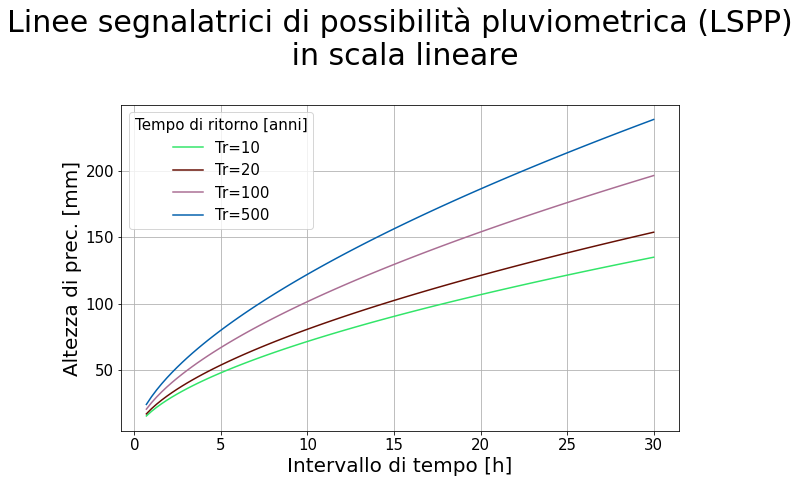

In [19]:
ag=inh.plot(color=c,figsize=(10,6))    
ag.set_title('Linee segnalatrici di possibilità pluviometrica (LSPP)\n in scala lineare\n')
ag.set_ylabel('Altezza di prec. [mm]')
ag.set_xlabel('Intervallo di tempo [h]')
ag.grid(True)
ag.legend (title= "Tempo di ritorno [anni]")

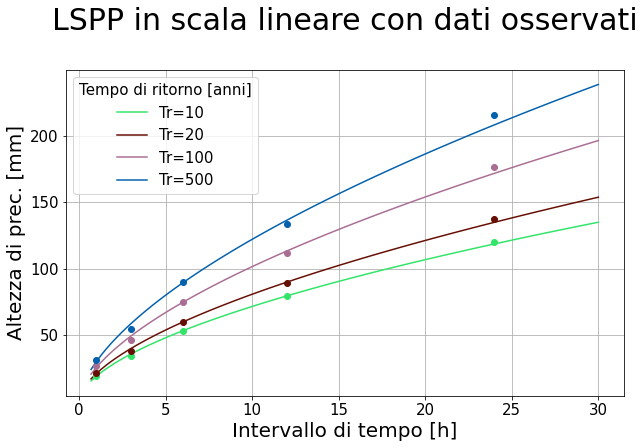

In [20]:

ag=inh.plot(color=c,figsize=(10,6)) 
ag.set_title('LSPP in scala lineare con dati osservati\n')
ag.set_ylabel('Altezza di prec. [mm]')
ag.set_xlabel('Intervallo di tempo [h]')
ag.grid(True)
ag.legend (title= "Tempo di ritorno [anni]")

for i in r:
    ag=plot(pts[i],"o",color=colors[i])

#plt.xlim([0,30])
#plt.ylim([0,200])

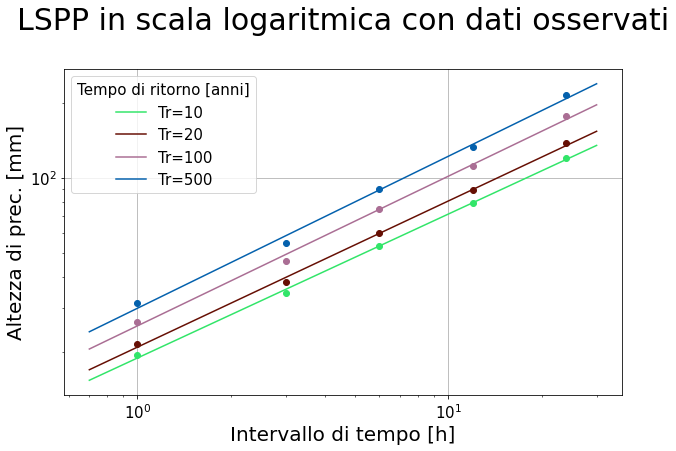

In [21]:
ag=inh.plot(color=c,figsize=(10,6))  
ag.set_yscale('log')                                               
ag.set_xscale('log')
ag.set_title('LSPP in scala logaritmica con dati osservati\n')
ag.set_ylabel('Altezza di prec. [mm]')
ag.set_xlabel('Intervallo di tempo [h]')
ag.grid(True)
legend = plt.legend (title= "Tempo di ritorno [anni]")

for i in r:
    ag=plot(pts[i],"o",color=colors[i])

#plt.xlim([0,30])
#plt.ylim([0,200])